# Optimizer and Loss

## Performance Metrics

Install the required packages

In [ ]:
%%capture
%pip install seaborn

Define the imports

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Picking a Loss Function

Let's start with **regression**. Key thing here is how much we want to penalize the outliers.

Given residulas $r = \hat{y} - y$, let's try several options

In [ ]:
# Define error range
residuals = np.linspace(-5, 5, 100)

# Define different loss functions
mae = np.abs(residuals)  # Mean Absolute Error
mse = residuals**2  # Mean Squared Error
rmse = np.sqrt(residuals**2)  # Root Mean Squared Error (same shape as MAE)
huber_d1 = np.where(np.abs(residuals) <= 1, 0.5 * residuals**2, np.abs(residuals) - 0.5)  # Huber loss with delta=1
huber_d10 = np.where(np.abs(residuals) <= 10, 0.5 * residuals**2, 10 * (np.abs(residuals) - 5))  # Huber loss with delta=10
logcosh = np.log(np.cosh(residuals))  # Log-Cosh Loss

# Plot
# plt.figure(figsize=(8, 6))
plt.plot(residuals, mae, label="MAE")
plt.plot(residuals, mse, label="MSE")
plt.plot(residuals, rmse, label="RMSE")
plt.plot(residuals, huber_d1, label="Huber (d=1)")
plt.plot(residuals, huber_d10, label="Huber (d=10)")
plt.plot(residuals, logcosh, label="LogCosh")

plt.ylim(0, 4)  # Set y-limit for better visualization
plt.xlabel("Residual")
plt.ylabel("Loss")
plt.title("Loss Functions for Regression")
plt.legend()
plt.grid()
plt.show()

For **classification** the choice is how we handle the edge cases: when $-log(\hat{y})$ (prediction probability for the correct in a binary classification case) is near 0 and 1.

In [ ]:
probs = np.linspace(0.001, 0.999, 100)

# Compute different loss functions
log_loss = -np.log(probs)  # -log(x), standard log loss for correct class
hinge_loss = np.maximum(0, 1 - probs)  # Hinge loss for binary classification
squared_hinge_loss = (np.maximum(0, 1 - probs)) ** 2  # Squared Hinge loss
logcosh_loss = np.log(np.cosh(1 - probs))  # Log-Cosh Loss

# Plot
# plt.figure(figsize=(8, 6))
plt.plot(probs, log_loss, label="-log(x) (Binary Cross-Entropy)", color="blue")
plt.plot(probs, hinge_loss, label="Hinge Loss", color="red")
plt.plot(probs, squared_hinge_loss, label="Squared Hinge Loss", color="green")
plt.plot(probs, logcosh_loss, label="LogCosh Loss", color="purple")

plt.xlabel("Probability of Correct Class (x)")
plt.ylabel("Loss")
plt.title("Loss Functions for Classification")
plt.legend()
plt.grid()
plt.show()

### Loss Functions Matter!

See PolyLoss paper: https://arxiv.org/abs/2204.12511

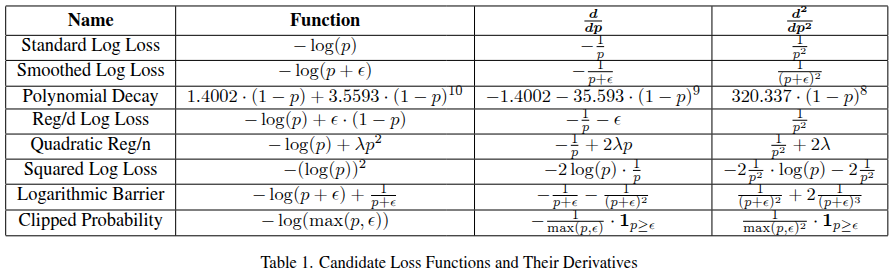

### JAX: Loss Functions for Regression

In [ ]:
import jax
import jax.numpy as jnp
import optax

  See https://optax.readthedocs.io/en/latest/api/losses.html
   - `optax.squared_error()` → **MSE**
   - `jnp.abs(y_pred - y_true).mean()` → **MAE**
   - `optax.huber_loss()` → **Huber Loss**

In [ ]:
y_true = jnp.array([3.0, -0.5, 2.0, 7.0])
y_pred = jnp.array([2.5, 0.0, 2.0, 8.0])

mse_loss = optax.squared_error(y_pred, y_true).mean()
mae_loss = jnp.abs(y_pred - y_true).mean()
huber_loss = optax.huber_loss(y_pred, y_true).mean()

print(f"MSE Loss: {mse_loss:.4f}")
print(f"MAE Loss: {mae_loss:.4f}")
print(f"Huber Loss: {huber_loss:.4f}")

### JAX: Loss Functions for Classification

For classification, we distinguish between:  
- **(Raw) logits** (unscaled model outputs)  
- **Probabilities** (logits transformed using softmax or sigmoid)  
- **Labels** (integer class indices)  
- **One-hot encoded labels** (binary vector representation of class labels)

Loss function signature expects a particular value.

In [ ]:
logits = jnp.array([1.0, -1.5, 0.8, -0.3])
labels = jnp.array([1, 0, 1, 0])

# Logits vs Labels [0,1]
bce_loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()

# !!! Logits vs Labels [-1,1]
labels_hinge = jnp.array([1, -1, 1, -1])
hinge_loss = optax.hinge_loss(logits, labels_hinge).mean()

print(f"Binary Cross-Entropy Loss: {bce_loss:.4f}")
print(f"Hinge Loss: {hinge_loss:.4f}")

## Optimizers

### Simple SGD

In [ ]:
# 1D quadratic function
def loss_fn(w):
    return (w - 3) ** 2

In [ ]:
grad_fn = jax.grad(loss_fn)

In [ ]:
learning_rate = 0.1

w = jnp.array(0.0)
print(f"Start: w = {w:.4f}, Loss = {loss_fn(w):.4f}")

for i in range(20):
    grad = grad_fn(w)  # Compute gradient dL/dw
    w = w - learning_rate * grad  # SGD update step
    print(f"Iteration {i+1}: w = {w:.4f}, Loss = {loss_fn(w):.4f}")

print("\nFinal optimized weight:", w)

### Accelaration SGD

Several ways to accelerate:
- **Momentum SGD**  
  $$
  v_{t+1} = \beta v_t + (1 - \beta) \nabla L(w_t)
  $$
  $$
  w_{t+1} = w_t - \eta v_{t+1}
  $$
  - Accumulates past gradients to **dampen oscillations**.
  - Helps move faster in **low-curvature directions**.
  - Example: `optax.sgd(momentum=0.9)`


- **Adagrad**  
  $$
  g_t = \nabla L(w_t)
  $$
  $$
  G_t = G_{t-1} + g_t^2
  $$
  $$
  w_{t+1} = w_t - \frac{\eta}{\sqrt{G_t} + \epsilon} g_t
  $$
  - Adjusts learning rates per-parameter.
  - **Good for sparse data** (e.g., NLP, embeddings).
  - Downside: **Aggressively decays learning rate** over time.

In [ ]:
from IPython.display import Image

display(Image(url="https://www.ruder.io/content/images/2016/09/contours_evaluation_optimizers.gif"))

In [ ]:
from IPython.display import Image

display(Image(url="https://www.ruder.io/content/images/2016/09/saddle_point_evaluation_optimizers.gif"))


Source: https://www.ruder.io/optimizing-gradient-descent/

### Using Optax

1️⃣ **Define an optimizer**
```python
opt = optax.adam(learning_rate=0.001)
```
2️⃣ **Initialize optimizer state**
```python
params = jnp.array(0.0)
opt_state = opt.init(params)
```
3️⃣ **Compute gradients**
```python
grad = jax.grad(loss_fn)(params)
```
4️⃣ **Update parameters**
```python
updates, opt_state = opt.update(grad, opt_state)
params = optax.apply_updates(params, updates)
```

In [ ]:
optimizers = {
    "SGD": optax.sgd(learning_rate=0.1),
    "Momentum": optax.sgd(learning_rate=0.1, momentum=0.9),
    "Adam": optax.adam(learning_rate=0.1),
    "RMSprop": optax.rmsprop(learning_rate=0.1)
}

num_epochs = 20

for opt_name, optimizer in optimizers.items():
    print(f"\n🔹 Using {opt_name} Optimizer 🔹")

    # Initialize weight
    w = jnp.array(0.0)

    # Initialize Optax optimizer state
    opt_state = optimizer.init(w)

    # Training loop
    for i in range(num_epochs):
        grad = grad_fn(w)  # Compute gradient

        # Compute optimizer update
        updates, opt_state = optimizer.update(grad, opt_state, w)

        # Apply update to w
        w = optax.apply_updates(w, updates)

        print(f"Iteration {i+1}: w = {w:.4f}, Loss = {loss_fn(w):.4f}")

    print(f"✅ Final optimized weight with {opt_name}: {w:.4f}")